In [10]:
import glob
import numpy as np
from numpy import array

from keras.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import (LSTM, Dense, Input, Reshape, ConvLSTM1D, ConvLSTM2D, Flatten,
Dropout, MaxPooling1D, MaxPooling2D, Bidirectional, BatchNormalization, concatenate,
Conv1D)
from keras.backend import set_session

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd

if tf.test.gpu_device_name():
    print("GPU {}".format(tf.test.gpu_device_name()))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
def convertToNDarray(data: list[str], format):
    df = pd.DataFrame()
    for fragment in data:
        csv = pd.read_csv(fragment)
        csv = csv.transpose()
        df = pd.concat([df, csv])
        
    return np.array(df).reshape(format)

In [3]:
def compareTwoData(data1, data2):
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [13, 5]
    column = 9
    raw = 2

    axs = []
    counterAxis = 0
    conterData1 = 0
    conterData2 = 0

    for i in range(0, column * raw):
        if i % 2 == 0:
            axs.append(fig.add_subplot(column, raw, i + 1))
            axs[counterAxis].plot(data1[conterData1], linewidth=0.8)
            axs[counterAxis].get_yaxis().set_ticks([])
            conterData1 += 1
            counterAxis += 1
        else:
            axs.append(fig.add_subplot(column, raw, i + 1))
            axs[counterAxis].plot(data2[conterData2], linewidth=0.8)
            axs[counterAxis].get_yaxis().set_ticks([])
            conterData2 += 1
            counterAxis += 1
            
    axs[0].set_title('Input')
    axs[1].set_title('Output')



In [60]:
filesTrainX = glob.glob("../dataset/train/trainX/*.csv")
filesTrainY = glob.glob("../dataset/train/trainY/*.csv")

filesValX = glob.glob("../dataset/val/valX/*.csv")
filesValY = glob.glob("../dataset/val/valY/*.csv")

format = (100,24,800)

X_train = convertToNDarray(filesTrainX, format)
Y_train = convertToNDarray(filesTrainY, format)

X_val = convertToNDarray(filesValX, format)
Y_val = convertToNDarray(filesValY, format)


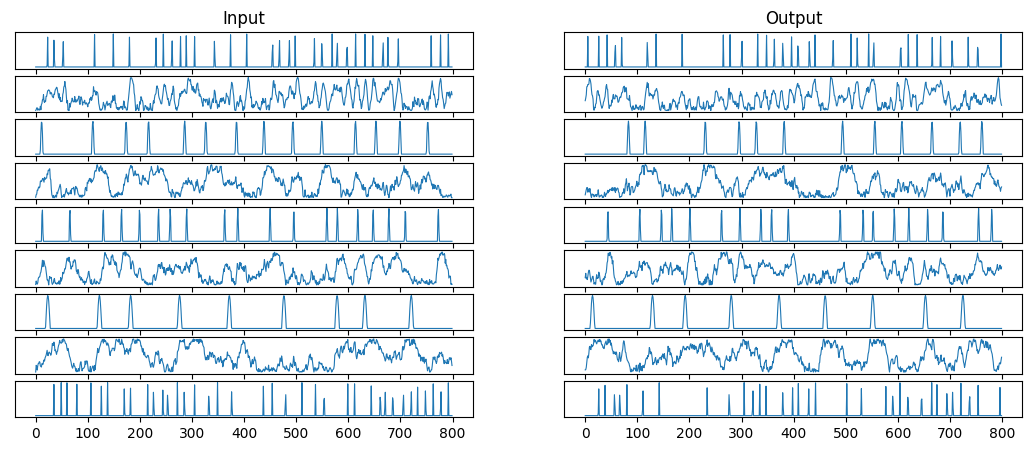

In [61]:
compareTwoData(X_train[0], Y_train[0])

In [67]:
# define model

inputs = Input(shape=(2,800), name='trailer_input')

tower1 = Conv1D(filters=20,kernel_size= 1,padding='same', activation='relu')(inputs)
tower1 = MaxPooling1D(pool_size=2, strides= 1, padding='same')(tower1)
tower1 = LSTM(128, return_sequences=True)(tower1)


tower2 = Conv1D(filters=20,kernel_size= 1,padding='same', activation='relu')(inputs)
tower2 = MaxPooling1D(pool_size=2, strides= 1, padding='same')(tower2)
tower2 = LSTM(128, return_sequences=True)(tower2)

merged = concatenate([tower1,tower2])
merged = Flatten()(merged)

final = Dense(128)(merged)
final = Dense(64)(final)
final = Dense(2 * 800, activation='linear')(merged)
outputs = Reshape((2,800))(final)

model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

In [ ]:
# Обучение модели
his = model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=1, validation_data=(X_val,Y_val))
model.save('snnaps.h5')

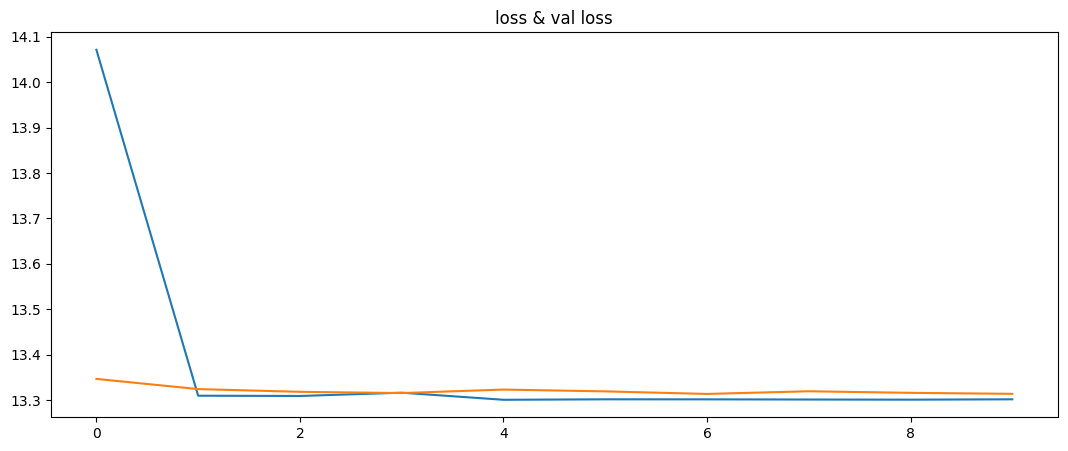

In [65]:
plt.title('loss & val loss')
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])

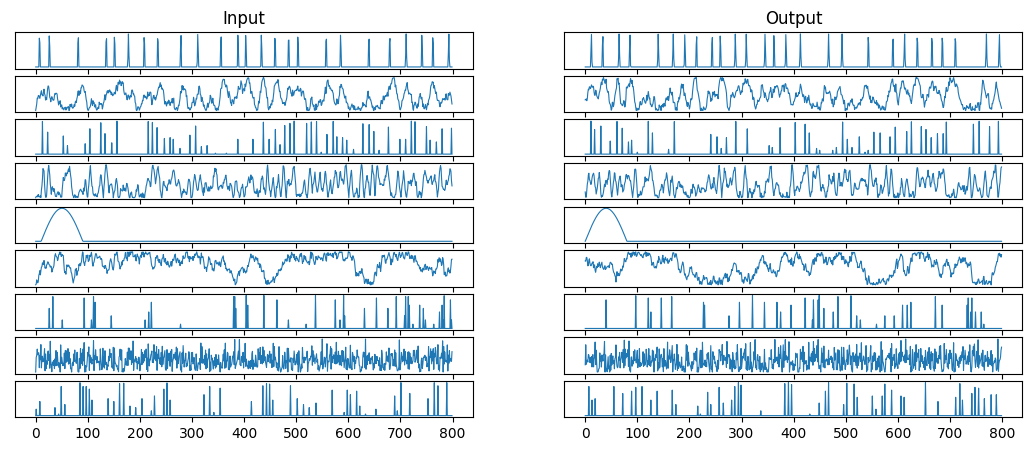

In [68]:
# show predict result
result = model.predict(X_val)
compareTwoData(X_val[0], result[0])